# AE 353 Project Code

In [87]:
from sympy import * # type: ignore
import numpy as np # type: ignore
import numpy.linalg as la # type: ignore
from scipy import linalg # type: ignore
import matplotlib.pyplot as plt # type: ignore
np.set_printoptions(suppress = False)

# Deriving the Equations of Motion

In [88]:
mass, g, Ixx, Iyy, Izz, lxy, lz = symbols("m, g, I_xx, I_yy, I_zz, l_xy, l_z")
p_x, p_y, p_z, v_x, v_y, v_z = symbols("p_x, p_y, p_z, v_x, v_y, v_z")
phi, theta, psi, omega_x, omega_y, omega_z = symbols("phi, theta, psi, omega_x, omega_y, omega_z")

mass = .98993
g = 9.81

p_W = Matrix([p_x, p_y, p_z])
v_B = Matrix([v_x, v_y, v_z])
omega_B = Matrix([omega_x, omega_y, omega_z])

R_x = Matrix([[1.,        0.,         0.],
              [0., cos(phi), -sin(phi)],
              [0., sin(phi),  cos(phi)]])
R_y = Matrix([[ cos(theta), 0., sin(theta)],
              [          0., 1.,          0.],
              [-sin(theta), 0., cos(theta)]])
R_z = Matrix([[cos(psi), -sin(psi), 0.],
              [sin(psi),  cos(psi), 0.],
              [       0.,         0., 1.]])

R_BtoW = R_z@R_y@R_x
R_WtoB = R_BtoW.T

p_dot = simplify(R_BtoW@v_B)

tau_x, tau_y, tau_z, Thrust = symbols("tau_x, tau_y, tau_z, T")
tau_B = Matrix([tau_x, tau_y, tau_z])

Gravity_W = Matrix([0.,0.,-mass*g])
Gravity_B = R_WtoB@Gravity_W

F_B = Matrix([0.,0.,Thrust])+Gravity_B

v_B_dot = simplify(1/mass*(F_B-omega_B.cross(mass*v_B)))

e_x = Matrix([1.,0.,0.])
e_y = Matrix([0.,1.,0.])
e_z = Matrix([0.,0.,1.])
M = Matrix.hstack(e_x, R_x.T@e_y, (R_y@R_x).T@e_z)
alpha = Matrix([phi, theta, psi])
alpha_dot = simplify(M.inv()@omega_B)

Ixx = 0.0071904  # The moment of inertia of the quadrotor in 
Iyy = 0.0071904  # The mass of the quadrotor in kg
Izz = 0.0004704  # The mass of the quadrotor in kg

x_rat = Ixx/0.0023
y_rat = Iyy/0.0023
z_rat = Izz/0.004
I_B = diag(Ixx, Iyy, Izz)
omega_B_dot = simplify(I_B.inv()@(tau_B-omega_B.cross(I_B@omega_B)))

f = Matrix.vstack(p_dot,v_B_dot,alpha_dot,omega_B_dot)
f

Matrix([
[1.0*v_x*cos(psi)*cos(theta) + 1.0*v_y*sin(phi)*sin(theta)*cos(psi) - 1.0*v_y*sin(psi)*cos(phi) + 1.0*v_z*sin(phi)*sin(psi) + 1.0*v_z*sin(theta)*cos(phi)*cos(psi)],
[1.0*v_x*sin(psi)*cos(theta) + 1.0*v_y*sin(phi)*sin(psi)*sin(theta) + 1.0*v_y*cos(phi)*cos(psi) - 1.0*v_z*sin(phi)*cos(psi) + 1.0*v_z*sin(psi)*sin(theta)*cos(phi)],
[                                                                                  -1.0*v_x*sin(theta) + 1.0*v_y*sin(phi)*cos(theta) + 1.0*v_z*cos(phi)*cos(theta)],
[                                                                                                             -1.0*omega_y*v_z + 1.0*omega_z*v_y + 9.81*sin(theta)],
[                                                                                                     1.0*omega_x*v_z - 1.0*omega_z*v_x - 9.81*sin(phi)*cos(theta)],
[                                                                                 1.0101724364349*T - 1.0*omega_x*v_y + 1.0*omega_y*v_x - 9.81*cos(phi)*cos(theta)],
[

# Finding a Valid Equilibrium Point

In [89]:
# We symbolically define all of the state and inputs for the system
m = [p_x, p_y, p_z, v_x, v_y, v_z, phi, theta, psi, omega_x, omega_y, omega_z] # States
n = [tau_x, tau_y, tau_z, Thrust] # Inputs
m_e = np.zeros(12) # Equilibrium point for state
n_e = np.block([np.zeros(3), g*mass]) # Equilibrium point for input

f_func = lambdify((*m,*n), f)
f_eq = f_func(*m_e, *n_e)
if np.all(np.round(f_eq, 14)==np.zeros(12)):
    print("This is a equilibrium point is good!")

## Computing the $A$ and $B$ matrices

In [90]:
A_func = lambdify((*m, *n), f.jacobian(m)) # Creating A matrix
B_func = lambdify((*m, *n), f.jacobian(n)) # Creating B matrix
A = A_func(*m_e, *n_e)
B = B_func(*m_e, *n_e)

## Sensor Model implementation

In [91]:
# Sensor model that takes in position and orientation and returns the mocap positions

g = Matrix([[p_x + 0.046875*sin(phi)*sin(psi) + 0.046875*sin(theta)*cos(phi)*cos(psi) + 0.25*cos(psi)*cos(theta)], 
            [p_y - 0.046875*sin(phi)*cos(psi) + 0.046875*sin(psi)*sin(theta)*cos(phi) + 0.25*sin(psi)*cos(theta)], 
            [p_z - 0.25*sin(theta) + 0.046875*cos(phi)*cos(theta)], 
            [p_x + 0.046875*sin(phi)*sin(psi) + 0.25*sin(phi)*sin(theta)*cos(psi) - 0.25*sin(psi)*cos(phi) + 0.046875*sin(theta)*cos(phi)*cos(psi)], 
            [p_y + 0.25*sin(phi)*sin(psi)*sin(theta) - 0.046875*sin(phi)*cos(psi) + 0.046875*sin(psi)*sin(theta)*cos(phi) + 0.25*cos(phi)*cos(psi)], 
            [p_z + 0.25*sin(phi)*cos(theta) + 0.046875*cos(phi)*cos(theta)], 
            [p_x + 0.046875*sin(phi)*sin(psi) + 0.046875*sin(theta)*cos(phi)*cos(psi) - 0.25*cos(psi)*cos(theta)], 
            [p_y - 0.046875*sin(phi)*cos(psi) + 0.046875*sin(psi)*sin(theta)*cos(phi) - 0.25*sin(psi)*cos(theta)], 
            [p_z + 0.25*sin(theta) + 0.046875*cos(phi)*cos(theta)], 
            [p_x + 0.046875*sin(phi)*sin(psi) - 0.25*sin(phi)*sin(theta)*cos(psi) + 0.25*sin(psi)*cos(phi) + 0.046875*sin(theta)*cos(phi)*cos(psi)], 
            [p_y - 0.25*sin(phi)*sin(psi)*sin(theta) - 0.046875*sin(phi)*cos(psi) + 0.046875*sin(psi)*sin(theta)*cos(phi) - 0.25*cos(phi)*cos(psi)], 
            [p_z - 0.25*sin(phi)*cos(theta) + 0.046875*cos(phi)*cos(theta)]])
om = [p_x, p_y, p_z, phi, theta, psi]
om_e = np.zeros(6)
g_func = lambdify((*om,), g)
q_e = g_func(*om_e).reshape(12,)

## Computing the sensor $C$ matrix

In [92]:
C_func = lambdify((*m,), g.jacobian(m)) # Creating C matrix
C = C_func(*m_e)

## Determining Controllability of the model

In [93]:
N = len(f)
W = B
for i in range(1,N):
    W = np.block([W, la.matrix_power(A,i)@B])
print(type(N))
if la.matrix_rank(W) == N:
    print("This system is controllable!")

<class 'int'>
This system is controllable!


## Determining Observability of the model

In [94]:
W = C
for i in range(1,N):
    W = np.block([[W], [C@la.matrix_power(A,i)]])
print(la.matrix_rank(W))
if la.matrix_rank(W) == N:
    print("This system is observable!")

12
This system is observable!


## Computing the $K$ and $L$ matrices using LQR
The elements for $Q$ and $R$ are found through $d = q^{-2}$ for the diagonal elements where $q$ represents the max desired values for the states and inputs.

In [95]:
# Function that applies the LQR problem to find the K and L matrices
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @ B.T @ P
    return K


# Max desired position, velocity, angles, and angular velocites
pos_max = 0.03
v_max = 3
angle_max = .5/180*np.pi
omega_max = .24
# Max desired toques and force
tau_max = .05
F_max = 3.3*2.6

# Evaluate the Q and R matrices for the gain matrix
Q = np.diag(np.array([pos_max,pos_max,pos_max/5,v_max,v_max,v_max/2, angle_max, angle_max, 2*np.pi, omega_max, omega_max, omega_max])**(-2))
R = np.diag(np.array([tau_max*x_rat,tau_max*y_rat,tau_max*z_rat,F_max])**(-2))

# Evaluating the 
pos_d = 600
v_d = 3
omega_d = 2
Q_o = np.diag([1,1,1,1,1,1,1,1,1,1,1,1])
R_o = np.diag([pos_d,pos_d,pos_d,v_d,v_d,v_d,1,1,1,omega_d,omega_d,omega_d])

# Computing the gain matrix and observer design L matrix
K = lqr(A, B, Q, R)
L = lqr(A.T, C.T, la.inv(R_o), la.inv(Q_o)).T

# Controller implementation

# Performance Goal 1
The drone shall hover 1m above ground for 2 minutes.

In [96]:
class Controller():
    def __init__(self, **kwargs):
        """
        Initializes the controller. You should initialize any member variables that
        the controller will use to their starting values. This function is called
        when a new instance of the Controller class is created.
        """
        # Here we define all of the intrincic characteristics for the controller
        #####################
        self.A = kwargs["A"]
        self.B = kwargs["B"]
        self.C = kwargs["C"]
        self.K = kwargs["K"]
        self.L = kwargs["L"]
        self.m_e = kwargs["m_e"]
        self.q_e = kwargs["q_e"]
        self.n_e = kwargs["n_e"]
        self.reset()
        #####################
    def reset(self):
        """
        Resets the controller to an initial state. You should reset any variables
        that track states, times, etc. in this function. This function will be 
        called just before the simulation starts running and any time the simulation
        is reset.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        # Starts off the xhat with the initial position without other drones and clears all of the data stored within the state estimate
        self.xhat = np.zeros(12)
    
     
    def run(self, **kwargs):
        """
        Runs the controller. Data is passed from the simulation environment to the
        controller via kwargs, the controller calculates the inputs to the system,
        and then returns them via a return statement
    
        Parameters
        ----------
        **kwargs : Dictionary
            A dictionary of data passed from the simulation environment to the 
            controller. Specific data is extracted from kwargs via the statement:
            kwargs["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys
            of kwargs for this project are as follows:

            kwargs["dt"] : float
                The simulation time step in seconds.

            kwargs["mocap_1"] : 3Vector
                The noisy measured position of mocap marker 1 (+x) in meters.
            
            kwargs["mocap_2"] : 3Vector
                The noisy measured position of mocap marker 2 (+y) in meters.
                
            kwargs["mocap_3"] : 3Vector
                The noisy measured position of mocap marker 1 (-x) in meters.
            
            kwargs["mocap_4"] : 3Vector
                The noisy measured position of mocap marker 2 (-y) in meters.
                
            kwargs["next_gate"] : 3Vector
                The position of the center of the next gate in meters.
            
            kwargs["dir_gate"] : 3Vector
                A direction vector pointing in the direction of the gate.
            
            kwargs["is_last_gate"] : bool
                A Boolean value that indicates whether or not the next gate is the last gate.
            
            kwargs["pos_others"] : List of 3Vectors
                A list of the positions of any other quadrotors in meters.
    
        Returns
        -------
        inputs : List with length equal to the number of inputs
            This is a list of the inputs calculated by the controller. In this
            project, there are four inputs, f_z, tau_x, tau_y, and tau_z.
            Therefore, inputs has the form:
            inputs = [tau_x, tau_y, tau_z, f_z]
        
        """


        e_max = 0.1
        dt = kwargs["dt"]
        o = np.block([kwargs["mocap_1"], kwargs["mocap_2"], kwargs["mocap_3"], kwargs["mocap_4"]]) # Sensor for the 4 mocaps
        p_hat = self.xhat[:3]
        p_goal = np.array([0,0,1])
        p_des = p_goal
        
        x_des = self.m_e
        x_des = np.block([p_des, np.zeros(9, float)]) # Set x_des to account for the new desired position
        u = -self.K@(self.xhat-x_des) # Closed loop feedback model
        n = (u+self.n_e) # Determine the required torques and forces
        y = o-self.q_e # Apply the sensor model
        xhatdot = self.A@self.xhat + self.B@u - self.L@(self.C@self.xhat-y) # State estimate evaluation
        self.xhat +=  xhatdot*dt
        return *n,


In [97]:
# Run the simulation and collect the simulation data
import ae353_quadrotor
# Initializing the datasets
team_list = [""]
# Creating the simulation
sim = ae353_quadrotor.Quadrotor_Sim(n_quadrotors=1,
                                    team_list=team_list,
                                    planet="Earth",
                                    use_keyboard=True,
                                    visualization=False,
                                    visualization_fr=45.,
                                    animation=False,
                                    verbose=False)
controller = Controller(A = A, B = B, C = C, K = K, L = L, m_e = m_e, q_e = q_e, n_e = n_e) # Creating the controller instance
# Runnning the simulation
(track_stats, data) = sim.run([controller],
                                sensor_noise=0.0,
                                collect_data=True,
                                max_time=130.,
                                verbose=False)
data = data[0]

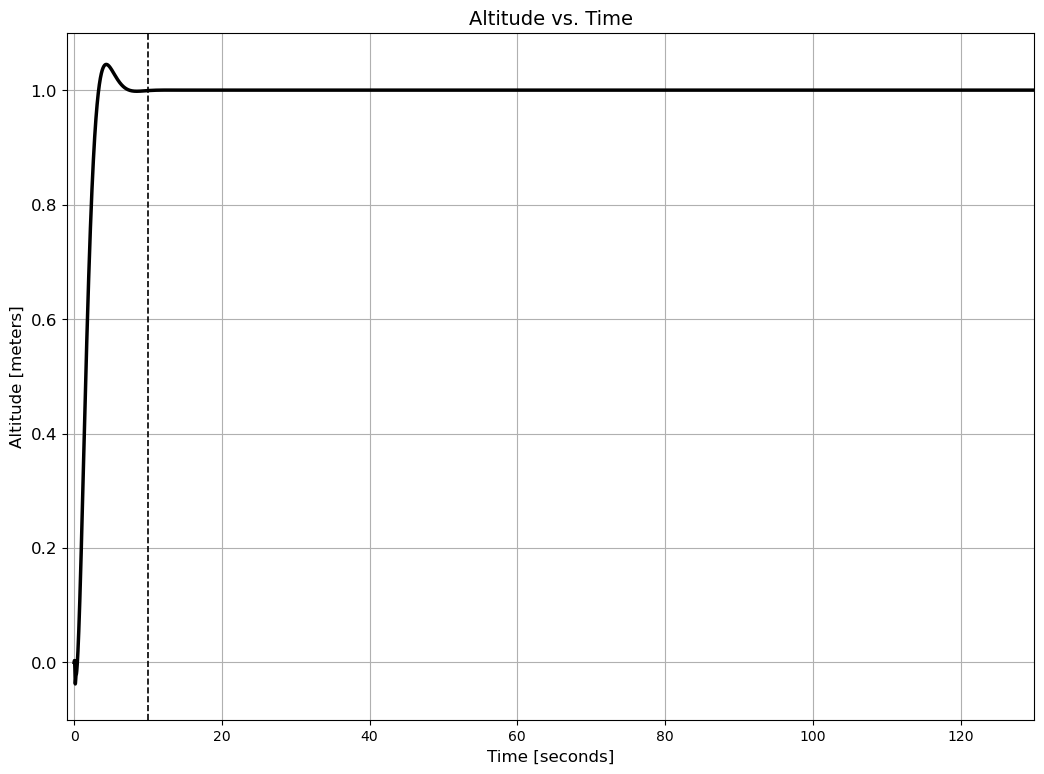

In [98]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(1, 1, figsize=(7.2*1.5, 5.4*1.5), sharex=False)

# Convert the position data to array
# Get the position

pos = np.array(data['position'])


# # Create a plot of the altitude versus time
x = [10,10]
y = [-.1, 1.1]
axes.plot(data['time'], pos[:,2], c="k", lw=2.5)
axes.plot(x, y, "k--", lw=1.2)

# Make plot 1 pretty
axes.set_xlabel("Time [seconds]", fontsize=12)
axes.set_ylabel("Altitude [meters]", fontsize=12)
axes.tick_params(axis='y', labelsize=12)
axes.set_title("Altitude vs. Time", fontsize=14)
axes.set_ylim(-.1,1.1)
axes.set_xlim(-1,130.)
axes.grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.savefig("P1_Checked.png")
plt.show()

In [99]:
P_x_points = pos[:,0]
P_y_points = pos[:,1]

R = np.sqrt(P_x_points**2 + P_y_points**2)
R_mag = la.norm(R)
R_mag

1.6167833314480464e-14

# Performance Goal 2

In [111]:
class Controller():
    def __init__(self, **kwargs):
        """
        Initializes the controller. You should initialize any member variables that
        the controller will use to their starting values. This function is called
        when a new instance of the Controller class is created.
        """
        # Here we define all of the intrincic characteristics for the controller
        #####################
        self.A = kwargs["A"]
        self.B = kwargs["B"]
        self.C = kwargs["C"]
        self.K = kwargs["K"]
        self.L = kwargs["L"]
        self.m_e = kwargs["m_e"]
        self.q_e = kwargs["q_e"]
        self.n_e = kwargs["n_e"]
        self.time = 0
        self.t_1 = kwargs["t_1"]
        self.reset()
        #####################
    def reset(self):
        """
        Resets the controller to an initial state. You should reset any variables
        that track states, times, etc. in this function. This function will be 
        called just before the simulation starts running and any time the simulation
        is reset.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        # Starts off the xhat with the initial position without other drones and clears all of the data stored within the state estimate
        self.xhat = np.zeros(12)
        self.XHAT = np.block(self.xhat)
        self.desireds = []
    
     
    def run(self, **kwargs):
        """
        Runs the controller. Data is passed from the simulation environment to the
        controller via kwargs, the controller calculates the inputs to the system,
        and then returns them via a return statement
    
        Parameters
        ----------
        **kwargs : Dictionary
            A dictionary of data passed from the simulation environment to the 
            controller. Specific data is extracted from kwargs via the statement:
            kwargs["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys
            of kwargs for this project are as follows:

            kwargs["dt"] : float
                The simulation time step in seconds.

            kwargs["mocap_1"] : 3Vector
                The noisy measured position of mocap marker 1 (+x) in meters.
            
            kwargs["mocap_2"] : 3Vector
                The noisy measured position of mocap marker 2 (+y) in meters.
                
            kwargs["mocap_3"] : 3Vector
                The noisy measured position of mocap marker 1 (-x) in meters.
            
            kwargs["mocap_4"] : 3Vector
                The noisy measured position of mocap marker 2 (-y) in meters.
                
            kwargs["next_gate"] : 3Vector
                The position of the center of the next gate in meters.
            
            kwargs["dir_gate"] : 3Vector
                A direction vector pointing in the direction of the gate.
            
            kwargs["is_last_gate"] : bool
                A Boolean value that indicates whether or not the next gate is the last gate.
            
            kwargs["pos_others"] : List of 3Vectors
                A list of the positions of any other quadrotors in meters.
    
        Returns
        -------
        inputs : List with length equal to the number of inputs
            This is a list of the inputs calculated by the controller. In this
            project, there are four inputs, f_z, tau_x, tau_y, and tau_z.
            Therefore, inputs has the form:
            inputs = [tau_x, tau_y, tau_z, f_z]
        
        """

        h_err = 0.01

        dt = kwargs["dt"]
        self.time += dt
        o = np.block([kwargs["mocap_1"], kwargs["mocap_2"], kwargs["mocap_3"], kwargs["mocap_4"]]) # Sensor for the 4 mocaps

        t_1 = self.t_1
        
        h_hat = self.xhat[2]
        if self.time < t_1:
            p_des = np.array([0,0,1])
        # elif self.time < t_1:
        #     p_des = np.array([2,0,1])         
        else: 
            omega = .25
            theta = (self.time-t_1)*omega
            p_des = np.array([0,2,1]) + 2*np.array([np.sin(theta), -np.cos(theta),0])
        x_des = self.m_e
        x_des = np.block([p_des, np.zeros(9)]) # Set x_des to account for the new desired position

        self.desireds.append(p_des)
        
        u = -self.K@(self.xhat-x_des) # Closed loop feedback model
        n = (u+self.n_e) # Determine the required torques and forces
        y = o-self.q_e # Apply the sensor model
        xhatdot = self.A@self.xhat + self.B@u - self.L@(self.C@self.xhat-y) # State estimate evaluation
        self.xhat +=  xhatdot*dt
        self.XHAT = np.block([[self.XHAT],[self.xhat]]) # This stores every value of xhat in the simulation for results
        return *n,


In [112]:
# Run the simulation and collect the simulation data
import ae353_quadrotor
# Initializing the datasets

team_list = [""]
# Creating the simulation
sim = ae353_quadrotor.Quadrotor_Sim(n_quadrotors=1,
                                    team_list=team_list,
                                    planet="Earth",
                                    use_keyboard=True,
                                    visualization=False,
                                    visualization_fr=45.,
                                    animation=False,
                                    verbose=False)

t_1 = 5.
t_f = t_1 + 60
controller = Controller(A = A, B = B, C = C, K = K, L = L, m_e = m_e, q_e = q_e, n_e = n_e, t_1 = t_1) # Creating the controller instance
controller.reset()
# Runnning the simulation
(track_stats, data) = sim.run([controller],
                                sensor_noise=0.0,
                                collect_data=True,
                                max_time=(t_f),
                                verbose=False)

data = data[0]

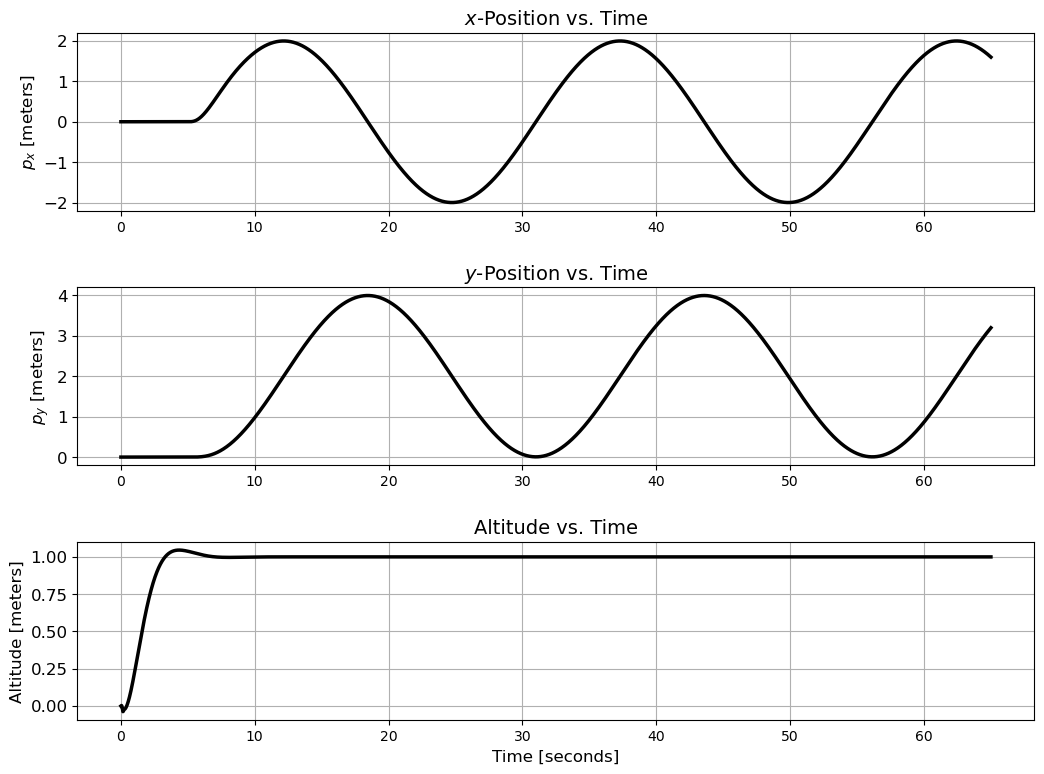

In [113]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(3, 1, figsize=(7.2*1.5, 5.4*1.5), sharex=False)

# Convert the position data to array
# Get the position

pos = np.array(data['position'])

# Create a plot of the ground path of the quadrotor
# Create a plot of the altitude versus time
axes[0].plot(data['time'], pos[:,0], c="k", lw=2.5)
axes[1].plot(data['time'], pos[:,1], c="k", lw=2.5)
axes[2].plot(data['time'], pos[:,2], c="k", lw=2.5)



# Make plot 1 pretty
# axes[0].set_xlabel("Time [seconds]", fontsize=12)
axes[0].set_ylabel("$p_x$ [meters]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("$x$-Position vs. Time", fontsize=14)
axes[0].grid()

# axes[1].set_xlabel("Time [seconds]", fontsize=12)
axes[1].set_ylabel("$p_y$ [meters]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("$y$-Position vs. Time", fontsize=14)
axes[1].grid()

axes[2].set_xlabel("Time [seconds]", fontsize=12)
axes[2].set_ylabel("Altitude [meters]", fontsize=12)
axes[2].tick_params(axis='y', labelsize=12)
axes[2].set_title("Altitude vs. Time", fontsize=14)
axes[2].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.savefig("P2_xyz.png")
plt.show()

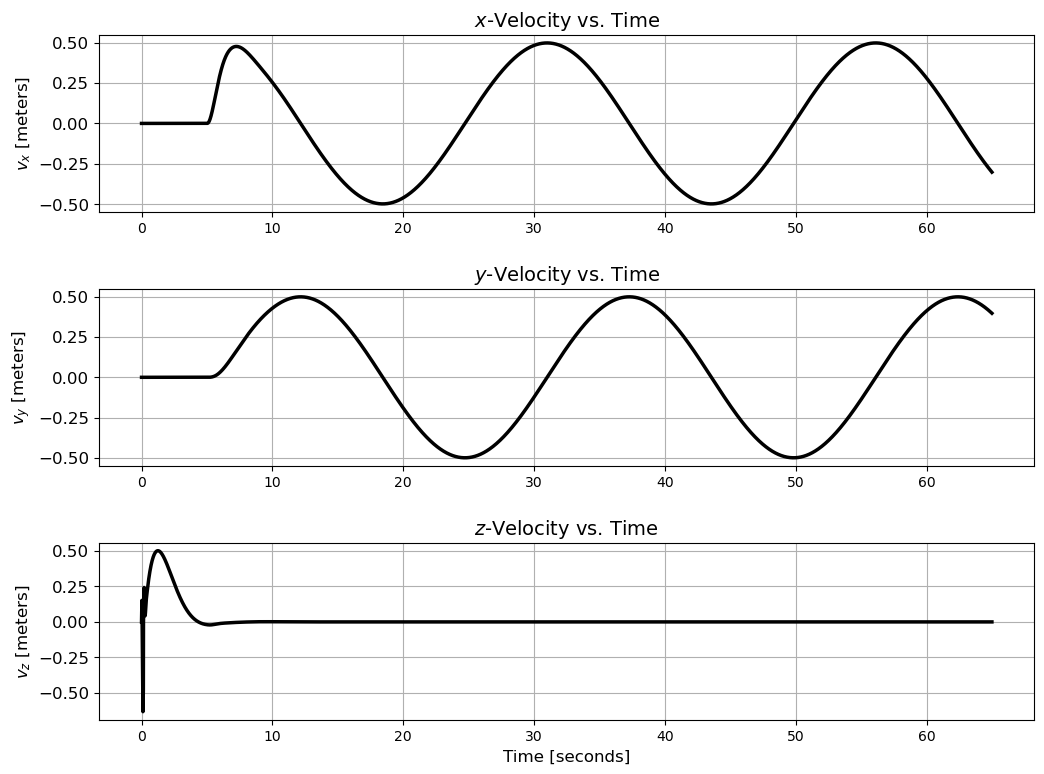

In [117]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(3, 1, figsize=(7.2*1.5, 5.4*1.5), sharex=False)

# Convert the position data to array
# Get the position

pos = np.array(data['velocity'])

# Create a plot of the ground path of the quadrotor
# Create a plot of the altitude versus time
axes[0].plot(data['time'], pos[:,0], c="k", lw=2.5)
axes[1].plot(data['time'], pos[:,1], c="k", lw=2.5)
axes[2].plot(data['time'], pos[:,2], c="k", lw=2.5)



# Make plot 1 pretty
# axes[0].set_xlabel("Time [seconds]", fontsize=12)
axes[0].set_ylabel("$v_x$ [meters]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("$x$-Velocity vs. Time", fontsize=14)
axes[0].grid()

# axes[1].set_xlabel("Time [seconds]", fontsize=12)
axes[1].set_ylabel("$v_y$ [meters]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("$y$-Velocity vs. Time", fontsize=14)
axes[1].grid()

axes[2].set_xlabel("Time [seconds]", fontsize=12)
axes[2].set_ylabel("$v_z$ [meters]", fontsize=12)
axes[2].tick_params(axis='y', labelsize=12)
axes[2].set_title("$z$-Velocity vs. Time", fontsize=14)
axes[2].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.savefig("P2_xyz_velocity.png")
plt.show()

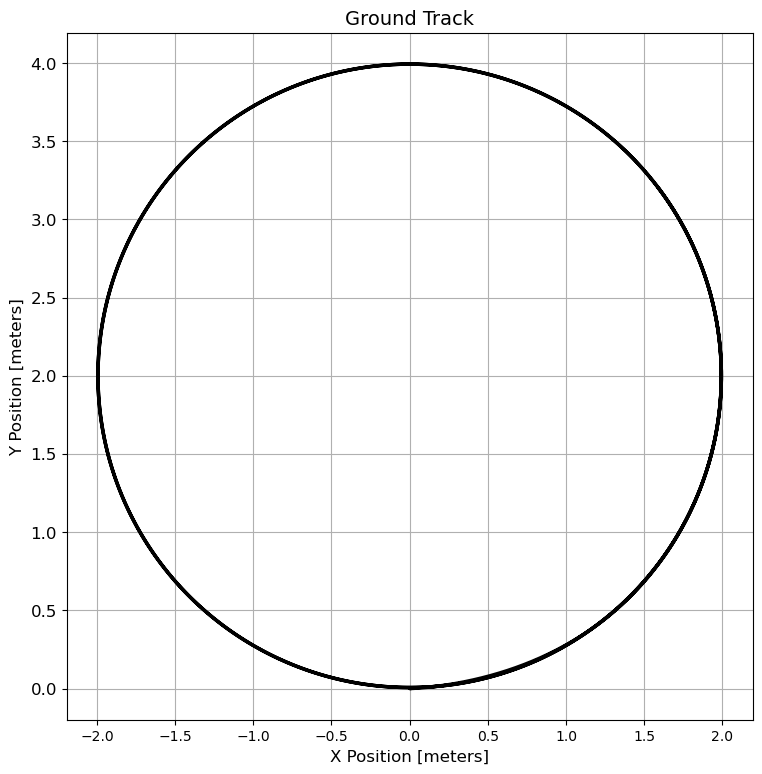

In [115]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(1, 1, figsize=(7.2*1.5, 5.4*1.5), sharex=False)

# Convert the position data to array
# Get the position

pos = np.array(data['position'])

# Create a plot of the ground path of the quadrotor
axes.plot(pos[:,0], pos[:,1], c="k", lw=2.5)

# Create a plot of the altitude versus time

# Make plot 0 pretty
axes.set_xlabel("X Position [meters]", fontsize=12)
axes.set_ylabel("Y Position [meters]", fontsize=12)
axes.tick_params(axis='y', labelsize=12)
axes.set_title("Ground Track", fontsize=14)
axes.set_aspect('equal', 'box')
axes.grid()


# Show the figure
fig.tight_layout(pad=2.0)
plt.savefig("P2_Ground_Track.png")
plt.show()

# Performance Goal 3

In [139]:
class Controller():
    def __init__(self, **kwargs):
        """
        Initializes the controller. You should initialize any member variables that
        the controller will use to their starting values. This function is called
        when a new instance of the Controller class is created.
        """
        # Here we define all of the intrincic characteristics for the controller
        #####################
        self.A = kwargs["A"]
        self.B = kwargs["B"]
        self.C = kwargs["C"]
        self.K = kwargs["K"]
        self.L = kwargs["L"]
        self.m_e = kwargs["m_e"]
        self.q_e = kwargs["q_e"]
        self.n_e = kwargs["n_e"]
        self.time = 0
        self.t_1 = kwargs["t_1"]
        self.t_2 = kwargs["t_2"]
        self.final = False
        self.reset()
        #####################
    def reset(self):
        """
        Resets the controller to an initial state. You should reset any variables
        that track states, times, etc. in this function. This function will be 
        called just before the simulation starts running and any time the simulation
        is reset.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        # Starts off the xhat with the initial position without other drones and clears all of the data stored within the state estimate
        self.xhat = np.zeros(12)
        self.XHAT = np.block(self.xhat)
        self.final = False
        self.desireds = []
    
     
    def run(self, **kwargs):
        """
        Runs the controller. Data is passed from the simulation environment to the
        controller via kwargs, the controller calculates the inputs to the system,
        and then returns them via a return statement
    
        Parameters
        ----------
        **kwargs : Dictionary
            A dictionary of data passed from the simulation environment to the 
            controller. Specific data is extracted from kwargs via the statement:
            kwargs["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys
            of kwargs for this project are as follows:

            kwargs["dt"] : float
                The simulation time step in seconds.

            kwargs["mocap_1"] : 3Vector
                The noisy measured position of mocap marker 1 (+x) in meters.
            
            kwargs["mocap_2"] : 3Vector
                The noisy measured position of mocap marker 2 (+y) in meters.
                
            kwargs["mocap_3"] : 3Vector
                The noisy measured position of mocap marker 1 (-x) in meters.
            
            kwargs["mocap_4"] : 3Vector
                The noisy measured position of mocap marker 2 (-y) in meters.
                
            kwargs["next_gate"] : 3Vector
                The position of the center of the next gate in meters.
            
            kwargs["dir_gate"] : 3Vector
                A direction vector pointing in the direction of the gate.
            
            kwargs["is_last_gate"] : bool
                A Boolean value that indicates whether or not the next gate is the last gate.
            
            kwargs["pos_others"] : List of 3Vectors
                A list of the positions of any other quadrotors in meters.
    
        Returns
        -------
        inputs : List with length equal to the number of inputs
            This is a list of the inputs calculated by the controller. In this
            project, there are four inputs, f_z, tau_x, tau_y, and tau_z.
            Therefore, inputs has the form:
            inputs = [tau_x, tau_y, tau_z, f_z]
        
        """
        e_max = .4
        h_err = 0.1
        h_goal = 1.
        dt = kwargs["dt"]
        self.time += dt
        o = np.block([kwargs["mocap_1"], kwargs["mocap_2"], kwargs["mocap_3"], kwargs["mocap_4"]]) # Sensor for the 4 mocaps
        p_hat = self.xhat[:3]
        t_1 = self.t_1
        omega_z_des = 0
        h_hat = self.xhat[2]
        v_des = np.zeros(3, float)
        psi_des = 0.
        p_goal = np.array([5,0,1])

        if self.time > self.t_2:
            p_goal = np.array([5,5,1])
        if self.time < t_1:
            if np.abs(h_goal-h_hat) < h_err/2:
                p_des = np.array([0,0,h_goal])
            else:
                p_des = p_hat + np.array([0,0,h_err])
        else:
            if self.final:
                    p_goal = np.array([5,5,0])
                    if np.abs(h_hat) > h_err/2:
                        p_des = p_hat + h_err*(p_goal-p_hat)/2
                    else:
                        p_des = p_goal
            else:
                mag_1 = la.norm(p_goal-p_hat)
                dir = (p_goal-p_hat)/mag_1
                if mag_1 < e_max:
                    p_des = p_goal
                    if self.time - self.t_3 > 9:
                        self.final = True
                        p_goal = np.array([5,5,0])
                        p_des = p_hat + h_err*(p_goal-p_hat)/8
                else:
                    p_des = e_max*(p_goal-p_hat) + p_hat
                    p_des[2]= h_goal + 0.1
                    self.t_3 = self.time                

        
        x_des = self.m_e
        x_des = np.block([p_des, v_des, 0, 0, psi_des, 0, 0, omega_z_des]) # Set x_des to account for the new desired position

        u = -self.K@(self.xhat-x_des) # Closed loop feedback model
        n = (u+self.n_e) # Determine the required torques and forces
        if self.final:
            u = np.zeros(4, float)
            n = np.zeros(4, float)

        y = o-self.q_e # Apply the sensor model
        xhatdot = self.A@self.xhat + self.B@u - self.L@(self.C@self.xhat-y) # State estimate evaluation
        self.xhat +=  xhatdot*dt
        self.XHAT = np.block([[self.XHAT],[self.xhat]]) # This stores every value of xhat in the simulation for results
        return *n,


In [140]:
# Run the simulation and collect the simulation data
import ae353_quadrotor
# Initializing the datasets



team_list = [""]
# Creating the simulation
sim = ae353_quadrotor.Quadrotor_Sim(n_quadrotors=1,
                                    team_list=team_list,
                                    planet="Earth",
                                    use_keyboard=True,
                                    visualization=False,
                                    visualization_fr=45.,
                                    animation=False,
                                    verbose=False)

t_1 = 6.
controller = Controller(A = A, B = B, C = C, K = K, L = L, m_e = m_e, q_e = q_e, n_e = n_e, t_1 = t_1, t_2 = 15) # Creating the controller instance
controller.reset()
# Runnning the simulation
(track_stats, data) = sim.run([controller],
                                sensor_noise=0.0,
                                collect_data=True,
                                max_time=(30.),
                                verbose=False)
data = data[0]

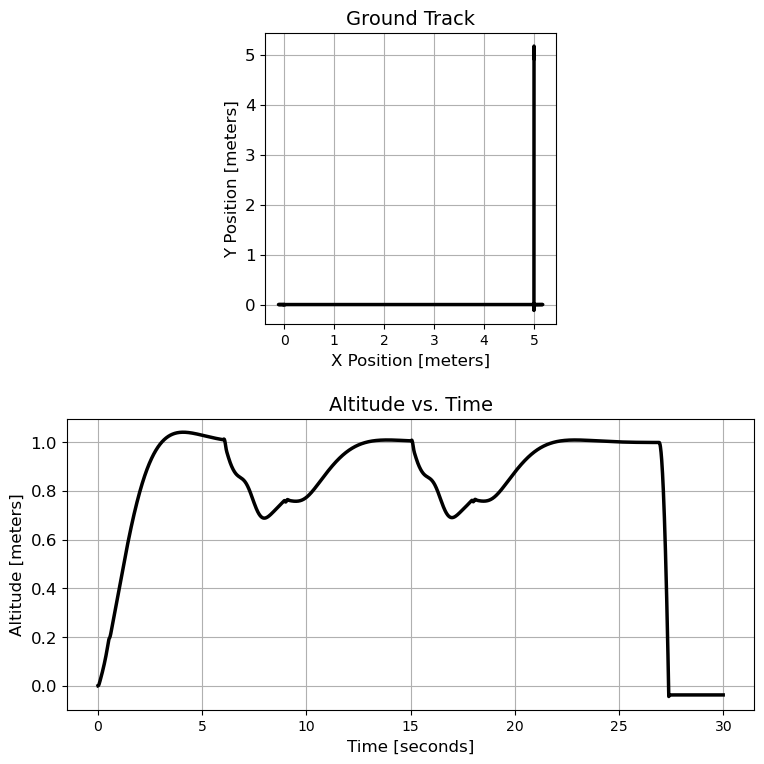

In [141]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=False)

# Convert the position data to array
# Get the position

pos = np.array(data['position'])

# Create a plot of the ground path of the quadrotor
axes[0].plot(pos[:,0], pos[:,1], c="k", lw=2.5)

# Create a plot of the altitude versus time
axes[1].plot(data['time'], pos[:,2], c="k", lw=2.5)

# Make plot 0 pretty
axes[0].set_xlabel("X Position [meters]", fontsize=12)
axes[0].set_ylabel("Y Position [meters]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Ground Track", fontsize=14)
axes[0].set_aspect('equal', 'box')
axes[0].grid()

# Make plot 1 pretty
axes[1].set_xlabel("Time [seconds]", fontsize=12)
axes[1].set_ylabel("Altitude [meters]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Altitude vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.savefig("P3_Plots1.png")
plt.show()

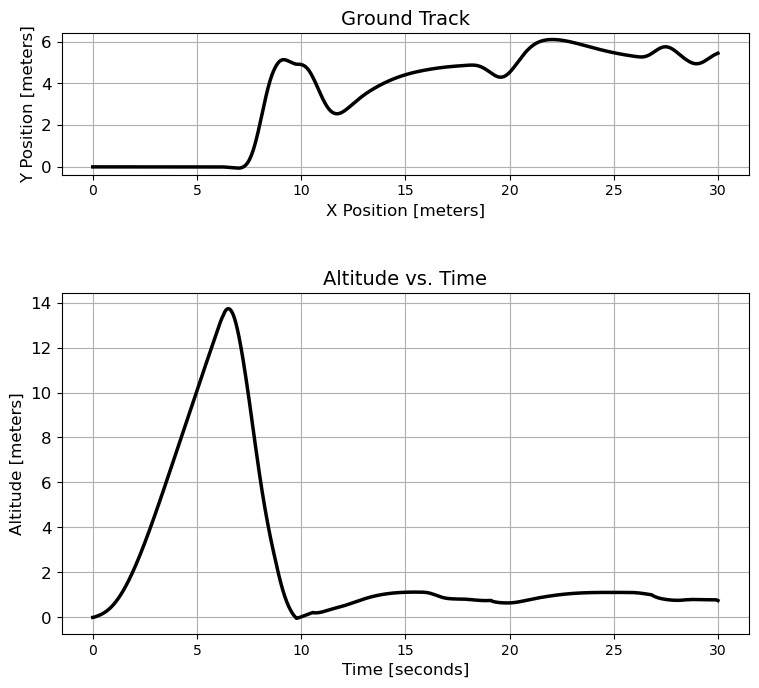

In [138]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=False)

# Convert the position data to array
# Get the position

pos = np.array(data['position'])

# Create a plot of the ground path of the quadrotor
axes[0].plot(data["time"], pos[:,0], c="k", lw=2.5)

# Create a plot of the altitude versus time
axes[1].plot(data['time'], pos[:,2], c="k", lw=2.5)

# Make plot 0 pretty
axes[0].set_xlabel("X Position [meters]", fontsize=12)
axes[0].set_ylabel("Y Position [meters]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Ground Track", fontsize=14)
axes[0].set_aspect('equal', 'box')
axes[0].grid()

# Make plot 1 pretty
axes[1].set_xlabel("Time [seconds]", fontsize=12)
axes[1].set_ylabel("Altitude [meters]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Altitude vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()